# Classify malaria infected cells

## Imports, Hyperparameters and loading the Data

In [57]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.image import ResizeMethod
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

In [58]:
## HYPERPARAMETERS
# Data processing
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 32
SHUFFLE_SIZE = 16


# Training
EPOCHS = 30
LEARNING_RATE = 0.0001

# loss
LOSS_FUNCTION = tf.keras.losses.BinaryCrossentropy()
# optimizer
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)

In [59]:
(training_ds_raw, test_ds_raw), info = tfds.load("Malaria", split=["train[:80%]","train[-20%:]"], with_info=True)

## Have a look at the dataset

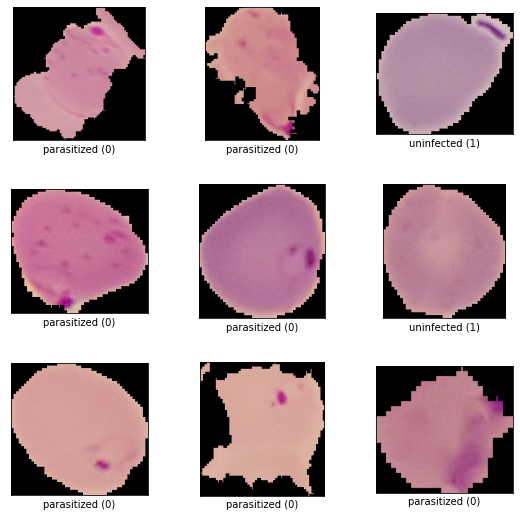

9 Examples


In [60]:
tfds.show_examples(test_ds_raw, info)
print("9 Examples")

## Preprocessing and Setup

In [75]:
def unzip(dataset):
    """
    unzips the malaria dataset to two seperate datasets.
    return a, b -> dataset a contains the images, b the labels
    """
    a = dataset.map(lambda x: x["image"])
    b = dataset.map(lambda x: x["label"])
    return a, b

In [64]:
def build_pipeline(dataset, batchsize, shuffle_buffer):
    # split ds to image and label datasets
    image, label = unzip(dataset)

    # normalise the color channels
    image = image.map(lambda img: tf.image.per_image_standardization(img))

    # resize the images
    image = image.map(lambda img: tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH)))

    # one hot the labels
    label = label.map(lambda l: tf.reshape(tf.one_hot(l, 2), shape=(-1,)))

    # zip them back together
    ds = tf.data.Dataset.zip((image, label))

    # shuffle, batch and prefetch the dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.batch(batchsize)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [65]:
class Model(Model):
    def __init__(self):
        """
        creates a Model with 8 Layers.
        Layer 1: Conv2D - 120 filters, relu
        Layer 2: MaxPooling2D - pool_size(2, 2)
        Layer 3-5: Conv2D - 100, 80, 60 filters, relu
        Layer 6: MaxPooling2D - pool_size(2,2)
        Layer 7: GlobalAveragePooling2D
        Layer 8: Dense - 2 (output)units, softmax
        """
        super(Model, self).__init__()
        self.conv_first = tf.keras.layers.Conv2D(filters=120, # 20-100
                                                 kernel_size=3, 
                                                 activation=tf.keras.activations.relu,
                                                 input_shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3),
                                                 padding="same")
        
        self.pooling_first = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
        
        self.conv_second = tf.keras.layers.Conv2D(filters=100,
                                                  kernel_size=3,
                                                  activation=tf.keras.activations.relu,
                                                  padding="same")
        
        self.conv_third = tf.keras.layers.Conv2D(filters=80,
                                                 kernel_size=3,
                                                 activation=tf.keras.activations.relu,
                                                 padding="same")
        
        self.conv_fourth = tf.keras.layers.Conv2D(filters=60,
                                                  kernel_size=3,
                                                  activation=tf.keras.activations.relu,
                                                  padding="same")
        
        self.pooling_second = tf.keras.layers.MaxPooling2D(pool_size=(2,2))

        self.global_average_layer = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')

        self.output_layer = tf.keras.layers.Dense(2,
                                                  activation=tf.keras.activations.softmax)
    
    @tf.function
    def call(self, x):
        x = self.conv_first(x)
        x = self.pooling_first(x)
        x = self.conv_second(x)
        x = self.conv_third(x)
        x = self.conv_fourth(x)
        x = self.pooling_second(x)

        x = self.global_average_layer(x)
        x = self.output_layer(x)
        return x
        

In [66]:
# taken from Tensorflow_Intro.ipynb
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
      prediction = model(input)
      loss = loss_function(target, prediction)
      gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
      prediction = model(input)
      sample_test_loss = loss_function(target, prediction)
      sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
      sample_test_accuracy = np.mean(sample_test_accuracy)
      test_loss_aggregator.append(sample_test_loss.numpy())
      test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [67]:
# thanks to Cornelius who shared this function which I adjusted a bit
def estimateTime(epoch, time_passed, number_of_epochs):
    """
    estimates the time it will take until the network is done with training.
    """
    epoch += 1
    time_per_epoch = time_passed / epoch
    number_of_epochs_left = number_of_epochs - epoch
    time_sec_remaining = number_of_epochs_left * time_per_epoch
    time_remain = str(datetime.timedelta(seconds=time_sec_remaining))
    return time_remain

## Training

In [69]:
# preprocess data
training_ds = build_pipeline(training_ds_raw, BATCH_SIZE, SHUFFLE_SIZE)
test_ds = build_pipeline(test_ds_raw, BATCH_SIZE, SHUFFLE_SIZE)

In [70]:
# things taken from Tensorflow_Intro.ipynb
tf.keras.backend.clear_session()

startTime = time.time()
print(f"Initialize, {datetime.timedelta(seconds=startTime)}")

# Initialize NN
model = Model()
# lists for vizualisation
training_losses = []

test_losses = []
test_accuracies = []

# let's test our Model how it performes on the test dataset before learning
test_loss, test_accuracy = test(model, test_ds, LOSS_FUNCTION)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how our Model performs on training dataset before learning
training_loss, _ = test(model, training_ds, LOSS_FUNCTION)
training_losses.append(training_loss)

print("Start", f"Training Loss: {training_loss}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}", sep="\n")

startTime = time.time()
# We train for before specified epochs.
for epoch in range(EPOCHS):
    print('Epoch: __ ', (epoch + 1))

    # perform a training step with each entry of our data pipeline and record the loss
    for (data, label) in training_ds:
        training_loss = train_step(model, data, label, LOSS_FUNCTION, OPTIMIZER)
    training_losses.append(training_loss)

    # check how our Model performs after one learning epoch on our test dataset and record it as well
    test_loss, test_accuracy = test(model, test_ds, LOSS_FUNCTION)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Training Loss: {training_loss}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Finish in: {estimateTime(epoch, time.time() - startTime, EPOCHS)}")

Initialize, 18591 days, 18:23:03.635721
Start
Training Loss: 4.154974460601807, Test Loss: 4.1934943199157715, Test Accuracy: 0.4956647398843931
Epoch: __  1
Training Loss: 0.4900749921798706, Test Loss: 0.4994279146194458, Test Accuracy: 0.7597543352601156, Finish: 0:47:31.074883
Epoch: __  2
Training Loss: 0.331468403339386, Test Loss: 0.30973634123802185, Test Accuracy: 0.8759031791907514, Finish: 0:34:52.169984
Epoch: __  3
Training Loss: 0.18685317039489746, Test Loss: 0.230337455868721, Test Accuracy: 0.9188945086705202, Finish: 0:30:05.064251
Epoch: __  4
Training Loss: 0.0475681871175766, Test Loss: 0.18912331759929657, Test Accuracy: 0.9342485549132948, Finish: 0:27:16.792447
Epoch: __  5
Training Loss: 0.1006239727139473, Test Loss: 0.1731937974691391, Test Accuracy: 0.9423771676300579, Finish: 0:25:14.803852
Epoch: __  6
Training Loss: 0.07215023040771484, Test Loss: 0.1706443578004837, Test Accuracy: 0.946893063583815, Finish: 0:23:36.593757
Epoch: __  7
Training Loss: 0.11

## Visualization

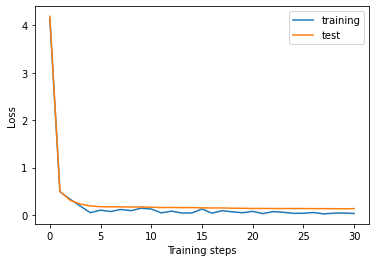

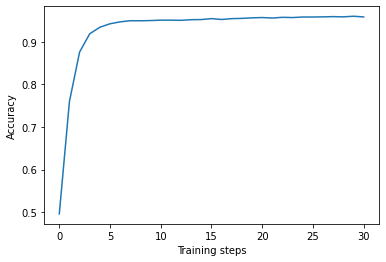

Max Accuracy: 0.9600794797687862


In [74]:
# taken from Tensorflow_Intro.ipynb

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
print(f"Max Accuracy: {np.max(test_accuracies)}")